In [1]:
# Import necessary libraries
import pandas as pd
import gspread
from google.colab import auth
from google.auth import default
from google.auth.transport.requests import Request
from google.auth.credentials import AnonymousCredentials
from google.oauth2.service_account import Credentials
from google.cloud import bigquery
from google.colab import drive
from sklearn.metrics import precision_score, recall_score, f1_score
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import hstack
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Authenticate to Google Cloud
auth.authenticate_user()
credentials, project_id = default()
project_id = 'nth-victory-359310'

# Use the JSON key file to authenticate
creds = Credentials.from_service_account_file('/content/drive/MyDrive/Proyek/Recommendation System/nth-victory-359310-450e996fc246.json')

# Create BigQuery client
client = bigquery.Client(credentials=creds, project=project_id)

# Define the SQL query
query = """
  SELECT
      o.order_id,
      oi.product_id,
      oi.user_id,
      p.category,
      p.name AS product_name,
      brand,
      p.department,
      o.created_at,
      o.status,
      oi.sale_price,
      p.cost,
      u.age,
      u.gender,
      u.state,
      u.country,
  FROM
      `bigquery-public-data.thelook_ecommerce.orders` AS o
  LEFT JOIN `bigquery-public-data.thelook_ecommerce.order_items` AS oi-- combine data from order_items
      ON o.order_id = oi.order_id
  LEFT JOIN `bigquery-public-data.thelook_ecommerce.users` AS u -- receive user profile
      ON oi.user_id = u.id
  LEFT JOIN `bigquery-public-data.thelook_ecommerce.products` AS p -- receive product info
      ON oi.product_id = p.id
  LEFT JOIN `bigquery-public-data.thelook_ecommerce.inventory_items` AS ii -- receive inventory info
      ON oi.inventory_item_id = ii.id
  ORDER BY
      o.created_at DESC
  LIMIT 20000 -- Limitation Data for Modelling
  """
# Query the data and convert to DataFrame
df_raw = client.query(query).to_dataframe()

In [4]:
# Display information about the DataFrame
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   order_id      20000 non-null  Int64              
 1   product_id    20000 non-null  Int64              
 2   user_id       20000 non-null  Int64              
 3   category      20000 non-null  object             
 4   product_name  19999 non-null  object             
 5   brand         19987 non-null  object             
 6   department    20000 non-null  object             
 7   created_at    20000 non-null  datetime64[us, UTC]
 8   status        20000 non-null  object             
 9   sale_price    20000 non-null  float64            
 10  cost          20000 non-null  float64            
 11  age           20000 non-null  Int64              
 12  gender        20000 non-null  object             
 13  state         20000 non-null  object             
 14  countr

In [5]:
# Create a copy of df_raw
df = df_raw.copy()
df.head()

,order_id,product_id,user_id,category,product_name,brand,department,created_at,status,sale_price,cost,age,gender,state,country
0,83908,8554,67152,Outerwear & Coats,Sutton Studio Cashmere Blend Coat,Sutton Studio,Women,2024-08-16 19:24:01.866122+00:00,Complete,99.970001,47.9856,61,F,Cataluña,Spain
1,83909,5333,67152,Pants & Capris,Anne Klein Women's Tuxedo Pant,Anne Klein,Women,2024-08-16 19:24:01.866122+00:00,Complete,109.000000,58.2060,61,F,Cataluña,Spain
2,83908,8308,67152,Outerwear & Coats,Carhartt Women's Sherpa Sweat Jacket,Carhartt,Women,2024-08-16 19:24:01.866122+00:00,Complete,90.000000,39.6900,61,F,Cataluña,Spain
3,83630,2501,66940,Active,Shock Absorber Women's Run Sports Bra,Shock Absorber,Women,2024-08-16 19:22:58.447287+00:00,Complete,79.000000,36.3400,67,F,England,United Kingdom
4,83629,5557,66940,Pants & Capris,Allegra K Ladies Zip Fly Two Front Top Pockets...,Allegra K,Women,2024-08-16 19:22:58.447287+00:00,Processing,12.100000,6.5582,67,F,England,United Kingdom


In [6]:
# checking null in product_name
df[df['brand'].isnull()]

,order_id,product_id,user_id,category,product_name,brand,department,created_at,status,sale_price,cost,age,gender,state,country
372,81787,23769,65476,Outerwear & Coats,Stormtech Men's Chinook Fleece Vest,None,Men,2024-08-16 10:01:35.090838+00:00,Cancelled,45.000000,18.540000,25,M,Texas,United States
1606,77175,10598,61800,Intimates,JMS Comfort Lace with Hidden Shaper,None,Women,2024-08-14 18:52:36.164517+00:00,Shipped,16.580000,9.616400,26,F,Hebei,China
1670,118452,25135,94787,Socks,Volcom Men's Argyle Socks,None,Men,2024-08-14 18:26:28.476126+00:00,Processing,22.480000,12.476400,56,M,Guangdong,China
2486,83588,16898,66908,Tops & Tees,Quiksilver Waterman Men's On The Rise,None,Men,2024-08-14 11:20:57.939704+00:00,Returned,25.000000,13.925000,38,M,Western Australia,Australia
8022,4399,21207,3519,Jeans,Ariat 9424 Men's M4 Low Rise Boot Tumbled,None,Men,2024-08-09 01:02:00+00:00,Complete,59.950001,30.754350,12,M,Maranhão,Brasil
9435,123858,21207,99072,Jeans,Ariat 9424 Men's M4 Low Rise Boot Tumbled,None,Men,2024-08-06 02:42:00+00:00,Processing,59.950001,30.754350,62,M,Colorado,United States
11192,3671,27640,2947,Swim,O'Neill Hangover Boardshorts,None,Men,2024-08-02 02:20:00+00:00,Shipped,49.500000,29.353500,35,M,Georgia,United States
13318,16275,15723,13054,Plus,Vintage Wayfarer Nerd Retro 80s Mirrored Sungl...,None,Women,2024-07-28 02:19:00+00:00,Complete,9.990000,4.875120,68,F,Virginia,United States
14612,25480,16559,20430,Tops & Tees,Gildan Adult Ultra CottonTM Sleeveless T-Shirt,None,Men,2024-07-24 12:59:00+00:00,Processing,25.990000,14.944250,45,M,Fujian,China
15941,33425,24287,26842,Outerwear & Coats,Adidas Men's Hiking Hooded 1Side Fleece Jacket,None,Men,2024-07-21 03:49:00+00:00,Shipped,89.949997,39.488049,23,M,Beijing,China


# Pre-Processing

In [7]:
# Checking duplicates
df.duplicated().sum()

0

In [8]:
# Checking Nilai Null
df.isnull().sum()

,0
order_id,0
product_id,0
user_id,0
category,0
product_name,1
brand,13
department,0
created_at,0
status,0
sale_price,0


To handle null values in the product_name and brand columns, I will fill them using the product_name that matches the existing product_id. If they remain null, I will fill them with 'No Product Name' and 'No Brand'.

In [9]:
# Mengisi nilai null pada 'product_name' berdasarkan 'product_id'
df['product_name'] = df.groupby('product_id')['product_name'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'No Product Name'))


In [10]:
df['brand'] = df.groupby('product_id')['brand'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'No Brand'))

In [11]:
df

,order_id,product_id,user_id,category,product_name,brand,department,created_at,status,sale_price,cost,age,gender,state,country
0,83908,8554,67152,Outerwear & Coats,Sutton Studio Cashmere Blend Coat,Sutton Studio,Women,2024-08-16 19:24:01.866122+00:00,Complete,99.970001,47.985600,61,F,Cataluña,Spain
1,83909,5333,67152,Pants & Capris,Anne Klein Women's Tuxedo Pant,Anne Klein,Women,2024-08-16 19:24:01.866122+00:00,Complete,109.000000,58.206000,61,F,Cataluña,Spain
2,83908,8308,67152,Outerwear & Coats,Carhartt Women's Sherpa Sweat Jacket,Carhartt,Women,2024-08-16 19:24:01.866122+00:00,Complete,90.000000,39.690000,61,F,Cataluña,Spain
3,83630,2501,66940,Active,Shock Absorber Women's Run Sports Bra,Shock Absorber,Women,2024-08-16 19:22:58.447287+00:00,Complete,79.000000,36.340000,67,F,England,United Kingdom
4,83629,5557,66940,Pants & Capris,Allegra K Ladies Zip Fly Two Front Top Pockets...,Allegra K,Women,2024-08-16 19:22:58.447287+00:00,Processing,12.100000,6.558200,67,F,England,United Kingdom
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,12666,3545,10154,Dresses,Plus Size Embroidery Print Empire Waist Maxi D...,eVogues Apparel,Women,2024-07-10 02:36:00+00:00,Shipped,39.990002,18.155461,45,F,Guizhou,China
19996,28293,2483,22728,Active,Natori Women's Sport Underwire Sport Bra,Natori,Women,2024-07-10 02:30:00+00:00,Shipped,48.000000,21.408000,32,F,Comunidad de Madrid,Spain
19997,28293,15012,22728,Maternity,Motherhood Maternity: Secret Fit Belly(r) Supe...,Motherhood Maternity,Women,2024-07-10 02:30:00+00:00,Shipped,39.980000,16.391800,32,F,Comunidad de Madrid,Spain
19998,28293,7370,22728,Skirts,TLB Luscious Style Tie Dye Long Skirt -Blue-Le...,TLB,Women,2024-07-10 02:30:00+00:00,Shipped,35.990002,16.195501,32,F,Comunidad de Madrid,Spain


# Exploratory Data Analysis

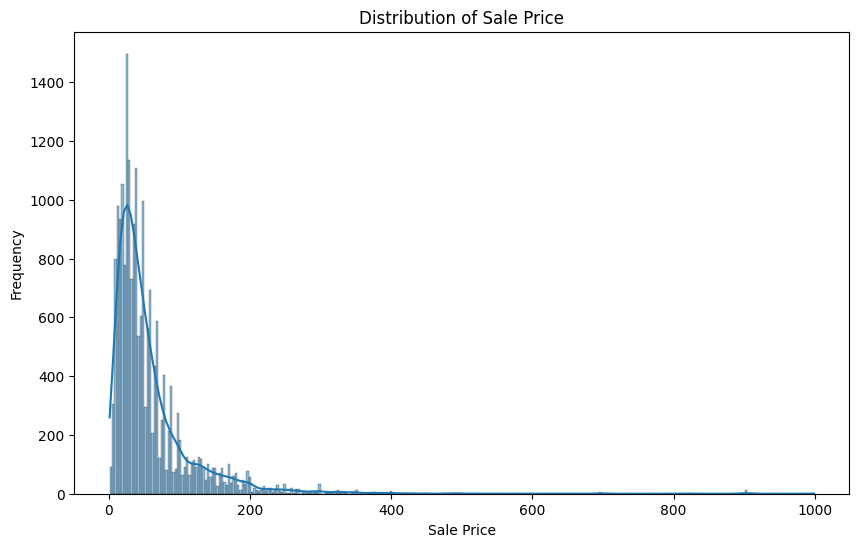

In [12]:
# Distribution of 'sale_price'
plt.figure(figsize=(10, 6))
sns.histplot(df['sale_price'], kde=True)
plt.title('Distribution of Sale Price')
plt.xlabel('Sale Price')
plt.ylabel('Frequency')
plt.show()


Based on the chart above, most transactions have a relatively low purchase price (0 - 100).

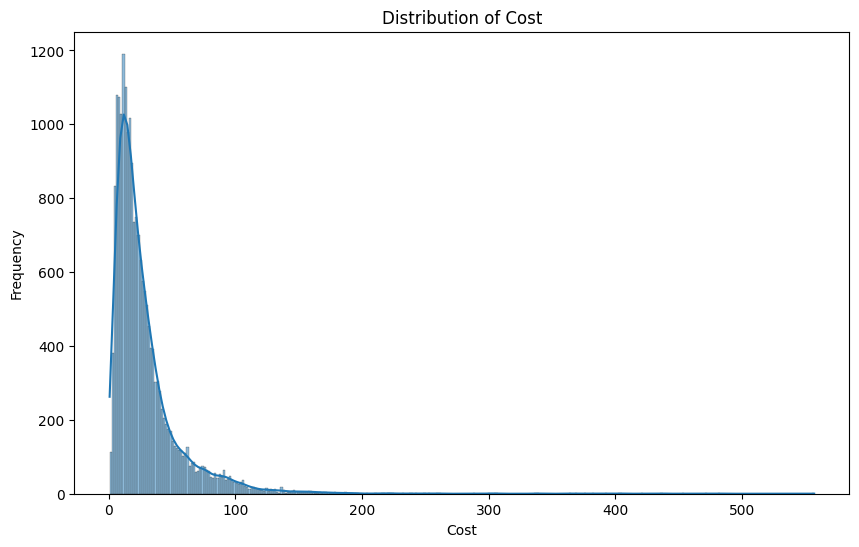

In [13]:
# Distribution of 'sale_price'
plt.figure(figsize=(10, 6))
sns.histplot(df['cost'], kde=True)
plt.title('Distribution of Cost')
plt.xlabel('Cost')
plt.ylabel('Frequency')
plt.show()

Based on the chart above, most cost have a relatively low cost price (0 - 100).

<ipython-input-14-c4a55ca43928>:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['month_year'] = df['created_at'].dt.to_period('M')


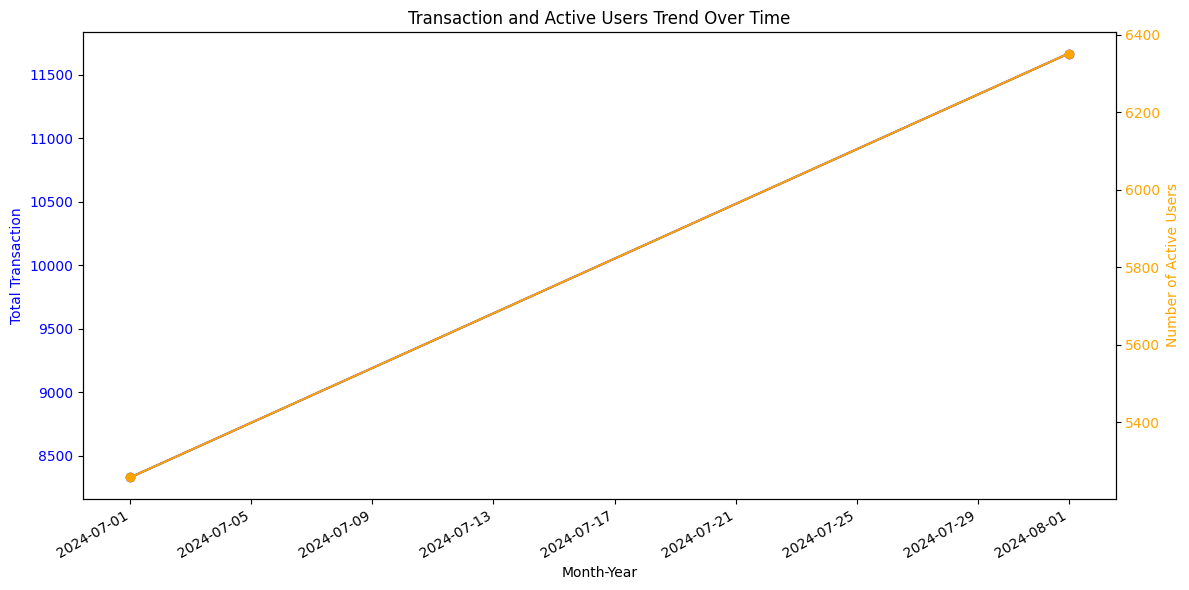

In [14]:
# Convert 'created_at' to datetime and extract month-year
df['created_at'] = pd.to_datetime(df['created_at'])
df['month_year'] = df['created_at'].dt.to_period('M')

# Calculate monthly Transaction
monthly_Transaction = df.groupby('month_year')['product_id'].count().reset_index()

# Calculate monthly active users
monthly_users = df.groupby('month_year')['user_id'].nunique().reset_index()

# Plotting the trends with dual y-axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Transaction trend on primary y-axis
ax1.plot(monthly_Transaction['month_year'].dt.to_timestamp(), monthly_Transaction['product_id'], marker='o', color='b', label='Total Transaction')
ax1.set_xlabel('Month-Year')
ax1.set_ylabel('Total Transaction', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_title('Transaction and Active Users Trend Over Time')

# Create secondary y-axis for active users
ax2 = ax1.twinx()
ax2.plot(monthly_users['month_year'].dt.to_timestamp(), monthly_users['user_id'], marker='o', color='orange', label='Active Users')
ax2.set_ylabel('Number of Active Users', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Rotate x-axis labels for better readability
fig.autofmt_xdate()

# Show plot
plt.tight_layout()
plt.show()

Both total sales and the number of active users exhibit a strong positive correlation. As the number of active users increases, total sales also rise consistently throughout the month.

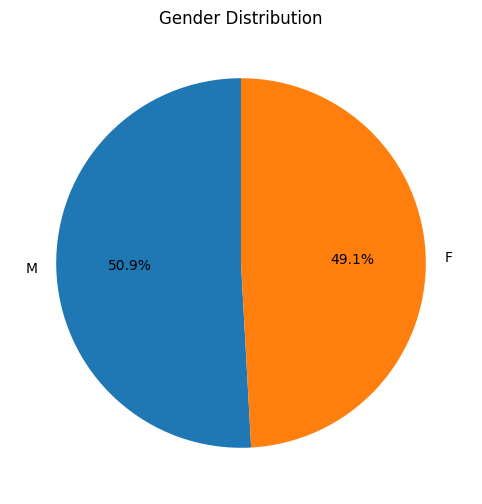

In [15]:
# Calculate gender distribution
gender_counts = df['gender'].value_counts()

# Create pie chart
plt.figure(figsize=(8, 6))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Gender Distribution')
plt.show()


The distribution of users by gender is very balanced. This indicates that the platform has broad and equal appeal to both genders.

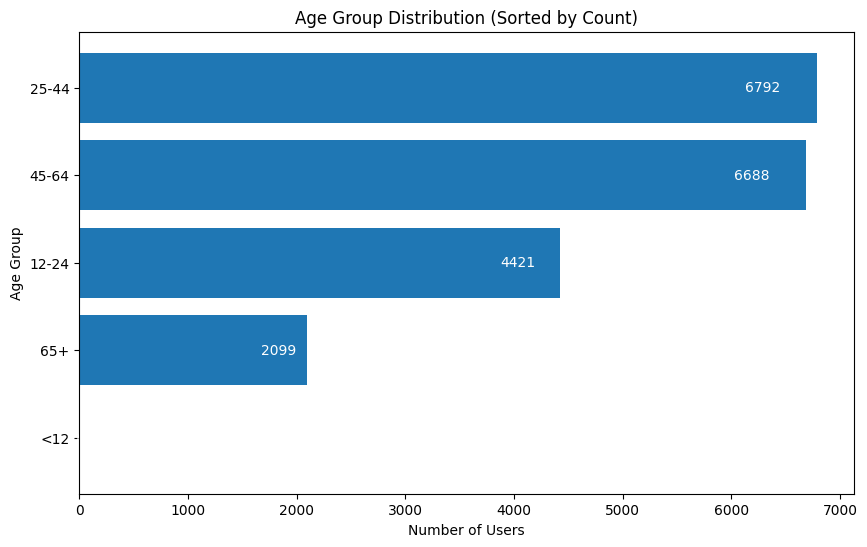

In [16]:
# Define age groups
age_bins = [0, 12, 25, 45, 65, 100]
age_labels = ['<12', '12-24', '25-44', '45-64', '65+']

# Categorize ages into groups
df['age_group'] = pd.cut(df['age'], bins=age_bins, labels=age_labels, right=False)

# Calculate age group distribution
age_group_counts = df['age_group'].value_counts()

# Sort age groups by count in descending order
age_group_counts = age_group_counts.sort_values(ascending=True)

# Create horizontal bar chart
plt.figure(figsize=(10, 6))
bars = plt.barh(age_group_counts.index, age_group_counts.values)

# Add data labels inside the bars
for bar in bars:
    plt.text(bar.get_width() - 0.05 * bar.get_width(),  # Position label inside bar, near the end
             bar.get_y() + bar.get_height() / 2,
             f'{int(bar.get_width())}',
             va='center',
             ha='right',
             color='white')

plt.xlabel('Number of Users')
plt.ylabel('Age Group')
plt.title('Age Group Distribution (Sorted by Count)')
plt.show()

The majority of customers are in the age range of 25-44.

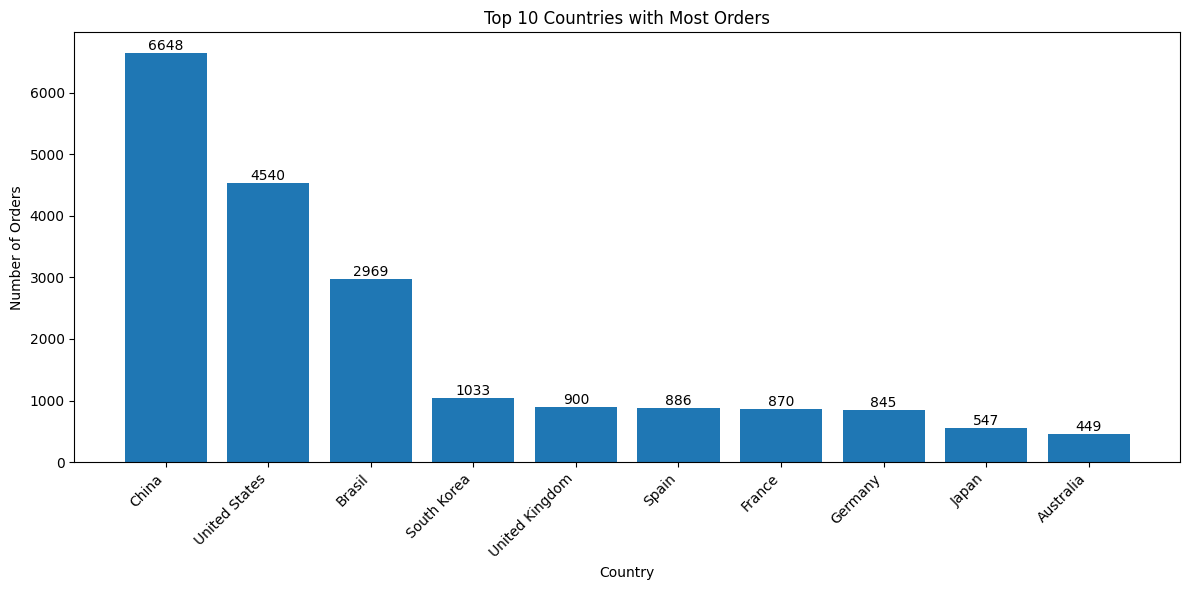

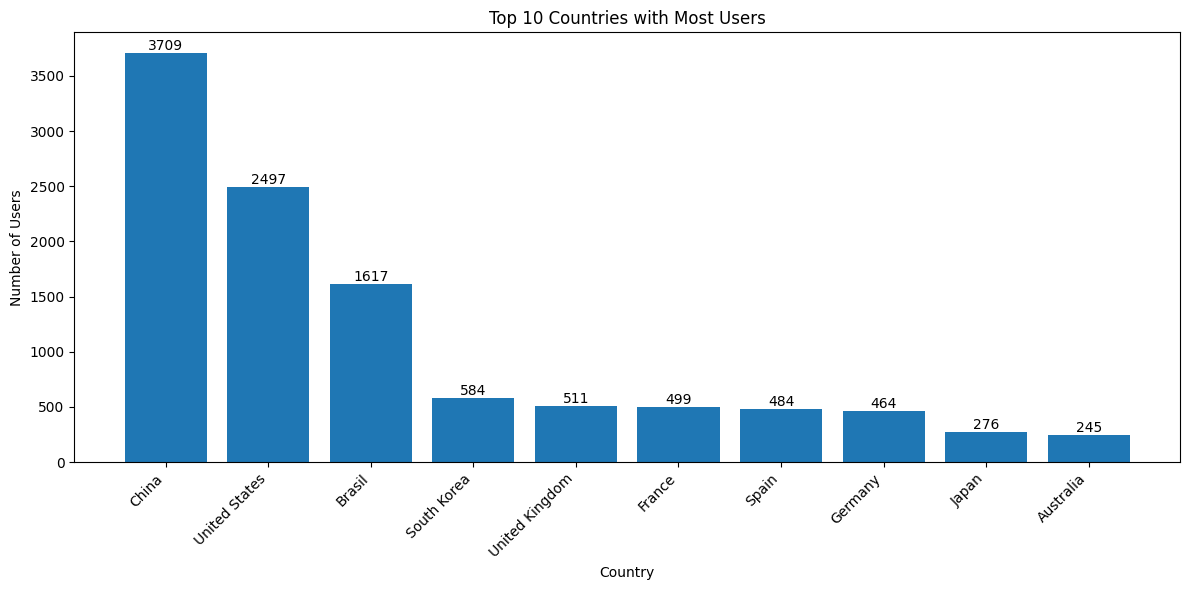

In [17]:
# Top 10 Countries with Most Orders
top_order_countries = df['country'].value_counts().head(10)

plt.figure(figsize=(12, 6))
bars = plt.bar(top_order_countries.index, top_order_countries.values)

for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height() + 0.1,
             str(int(bar.get_height())),
             ha='center', va='bottom')

plt.xlabel('Country')
plt.ylabel('Number of Orders')
plt.title('Top 10 Countries with Most Orders')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Top 10 Countries with Most Users
top_user_countries = df.groupby('country')['user_id'].nunique().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))
bars = plt.bar(top_user_countries.index, top_user_countries.values)

for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height() + 0.1,
             str(int(bar.get_height())),
             ha='center', va='bottom')

plt.xlabel('Country')
plt.ylabel('Number of Users')
plt.title('Top 10 Countries with Most Users')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


China is the country with the highest number of transactions and users.

# Feature Engineering

In [18]:
# One Hot Encoding for categorical column
encoder = OneHotEncoder(sparse=False)
ohe_matrix = encoder.fit_transform(df[['category', 'brand', 'department']])

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [19]:
# TF-IDF Vectorization for product name
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['product_name'])

In [20]:
# Combine OHE and TF-IDF
combined_matrix = hstack([tfidf_matrix, ohe_matrix])

# Calculate cosine from combined matrix
cosine_sim = cosine_similarity(combined_matrix, combined_matrix)

# Modeling : Content Based Recommendation System With FuzzyWuzzy

In [21]:
!pip install fuzzywuzzy

In [22]:
from fuzzywuzzy import process

# Create a function to get recommendations based on product name
def get_recommendations_fuzzywuzzy(product_name, cosine_sim=cosine_sim, top_n=10):
    """
    Get recommendations based on product name using fuzzywuzzy

    Parameters:
    -----------
    product_name : str
        The name of the product for which recommendations are to be generated.
    cosine_sim : numpy array
        The cosine similarity matrix.
    top_n : int
        The number of top recommendations to return.

    Returns:
    --------
    pandas DataFrame
        A DataFrame containing the top recommended products.
    """
    # Finding product name that has similarity using FuzzyWuzzy
    matching_string, score, index_matching = process.extractOne(product_name, df['product_name'])

    # Check if the closest match has a sufficient score (you can adjust this threshold)
    if score < 80:
        return f"No close match found for '{product_name}'."

    idx = df.index[df['product_name'] == matching_string][0]

    # Get similarity scores for all products with the given product
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort products based on similarity scores (from highest to lowest)
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get indices of the most similar products
    sim_scores = sim_scores[1:top_n+1]

    # Return product recommendations
    product_indices = [i[0] for i in sim_scores]
    return df[['product_name', 'category', 'brand', 'department', 'sale_price']].iloc[product_indices].reset_index().drop(columns=['index'])


/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [24]:
# Example Usage
input_product_name = input("Masukkan nama produk yang ingin dicari: ")
recommended_data = get_recommendations_fuzzywuzzy(input_product_name)
recommended_data

Masukkan nama produk yang ingin dicari: sock for men


,product_name,category,brand,department,sale_price
0,Quiksilver Men's Union Surplus Walkshort,Shorts,Quiksilver,Men,49.500000
1,Quiksilver Men's Full On Walkshort,Shorts,Quiksilver,Men,16.430000
2,Quiksilver Men's Full On Solid Walkshort,Shorts,Quiksilver,Men,52.000000
3,Quiksilver Men's Full On Solid Walkshort,Shorts,Quiksilver,Men,52.000000
4,Quiksilver Men's Full On Solid Walkshort,Shorts,Quiksilver,Men,49.500000
5,Quiksilver Men's Union Surplus Walk Short,Shorts,Quiksilver,Men,49.500000
6,Quiksilver Men's Staple Walkshort,Shorts,Quiksilver,Men,51.990002
7,Quiksilver Men's Nova Walkshort,Shorts,Quiksilver,Men,59.000000
8,Quiksilver Men's Rockefeller Walkshort,Shorts,Quiksilver,Men,903.000000
9,Quiksilver Waterman Men's Seaview Walkshort,Shorts,Quiksilver,Men,59.500000
